# Inspect TF Records

In [1]:
import os
import sys
print(sys.executable, sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import cv2
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from glob import glob
from os.path import join, abspath
from IPython.display import display, HTML

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# for local import 
sys.path.append(abspath(join('..', '..')))

from main.config import Config
from main.smpl import Smpl
from visualise.vis_util import draw_2d_on_image, show_2d_pose ,show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
class TfRecordConfig(Config):
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords')
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs_notebook')
    
# class Config is implemented as singleton, inizialize subclass first!
config = TfRecordConfig()

In [3]:
config.display()


Configurations:
BATCH_SIZE                     64
CUSTOM_REGRESSOR_IDX           {0: 'regressor_toes_right.npy', 7: 'regressor_toes_left.npy'}
CUSTOM_REGRESSOR_PATH          /home/mmc-user/workspace/hmr2.0/models/regressors
DATASETS                       ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m', 'total_cap']
DATA_DIR                       /data/ssd1/russales/tfrecords
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   False
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
INITIALIZE_CUSTOM_REGRESSOR    False
ITERATIONS                     3
JOINT_TYPE                  

### parse tf records example proto

In [4]:
def parse(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)

    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']

    return image, kp2d, kp3d, has_3d

def parse_test(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64),
        'sequence': tf.io.FixedLenFeature([], dtype=tf.string, default_value='NA')
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']
    sequence = features['sequence']
    return image, kp2d, kp3d, has_3d, sequence

In [5]:
def show_image(image, kp2d, vis):
    image = draw_2d_on_image(image, kp2d, vis=vis)
    plt.imshow(image)
    plt.show()

In [6]:
config.DATASETS = ['total_cap']

### show train/val examples 

In [7]:
def read_train_tfrecords(path):
    dataset = tf.data.TFRecordDataset(path).map(parse).shuffle(500)
    for x in dataset.take(10):
        image, kp2d, kp3d, has_3d = x[0], x[1], x[2], x[3]
        kp2d = kp2d.numpy()        

        #print('has3d: ', has_3d.numpy().astype(bool))
        print('visible kps: ', np.sum(kp2d[:, 2]))
        #print('kps: ', kp2d[:, :2])
        #print('vis: ', kp2d[:, 2])
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])
        #print('-----------------------------')

visible kps:  14.0


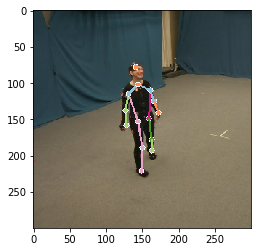

visible kps:  14.0


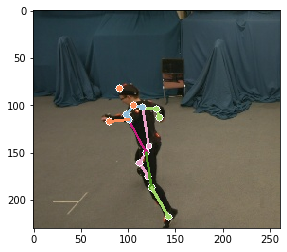

visible kps:  14.0


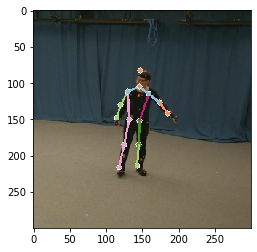

visible kps:  14.0


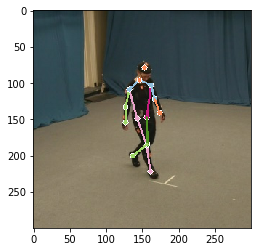

visible kps:  14.0


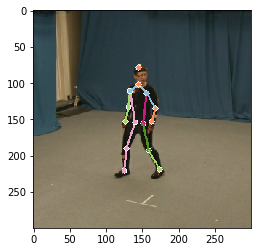

visible kps:  14.0


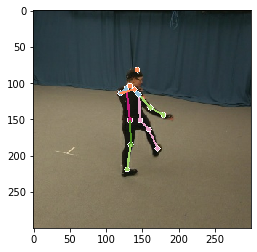

visible kps:  14.0


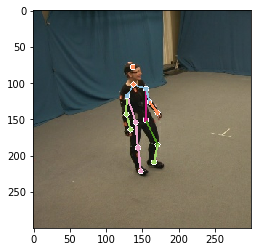

visible kps:  14.0


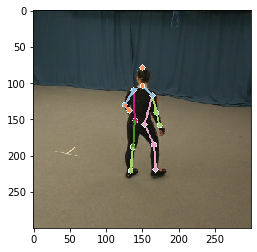

visible kps:  14.0


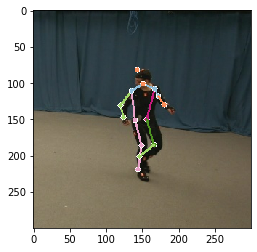

visible kps:  14.0


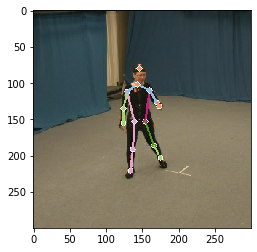

In [8]:
tf_record_dirs = [join(config.DATA_DIR, dataset, '*_train.tfrecord') for dataset in config.DATASETS]
tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]
random.shuffle(tf_records)

#tf_records = os.path.join("/data/ssd1/russales/new_records_test/mpii_3d/", "000_train.tfrecord")
read_train_tfrecords(tf_records)

### show test examples

In [9]:
def read_test_tfrecords(path):    
    dataset = tf.data.TFRecordDataset(path).map(parse_test).shuffle(3000)
    for image, kp2d, kp3d, has3d, sequence in dataset.take(10):
        print('sequence: ', sequence.numpy().decode('utf-8'))
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])    

sequence:  TC_S5_walking2_cam2


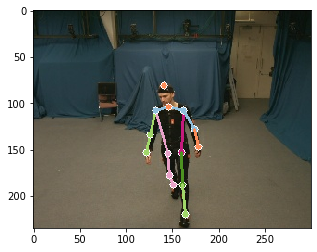

sequence:  TC_S5_walking2_cam8


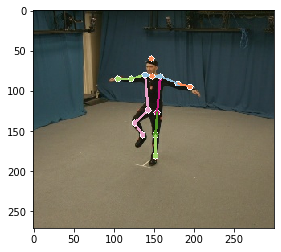

sequence:  TC_S2_acting3_cam2


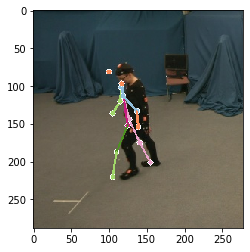

sequence:  TC_S2_freestyle3_cam1


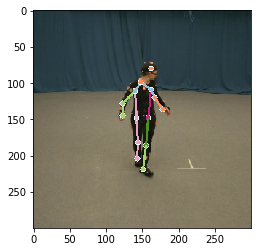

sequence:  TC_S4_acting3_cam6


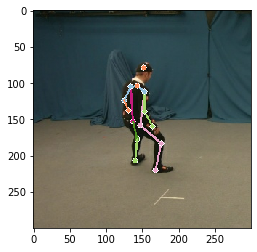

sequence:  TC_S4_acting3_cam8


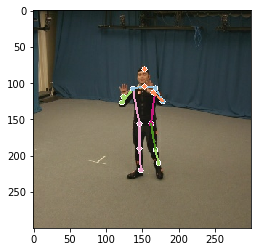

sequence:  TC_S4_acting3_cam6


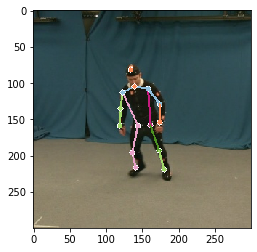

sequence:  TC_S3_freestyle3_cam2


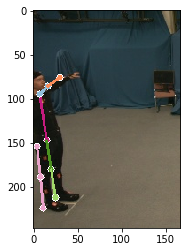

sequence:  TC_S3_freestyle3_cam8


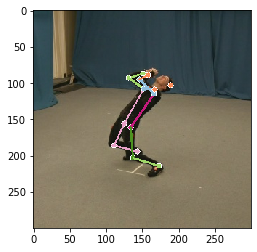

sequence:  TC_S3_freestyle3_cam8


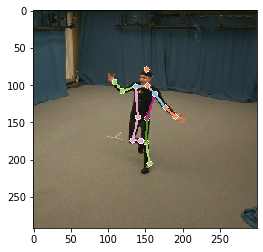

In [10]:
tf_record_dirs = [join(config.DATA_DIR, dataset, '*_test.tfrecord') for dataset in config.DATASETS]
tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]
random.shuffle(tf_records)
read_test_tfrecords(tf_records)

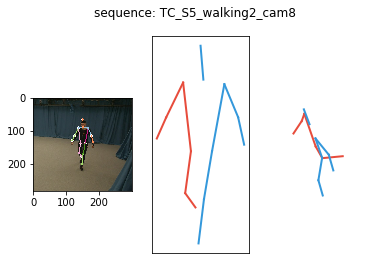

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

plt.axis('off')

dataset = tf.data.TFRecordDataset(tf_records).map(parse_test)
for image, kp2d, kp3d, has3d, sequence in dataset.take(1):
    fig.suptitle('sequence: {}'.format(sequence.numpy().decode('utf-8')))

    image = image.numpy()
    kp2d = kp2d.numpy()
    kp3d = kp3d.numpy()

    image = draw_2d_on_image(image, kp2d[:, :2], vis=kp2d[:, 2])
    ax1.imshow(image)

    show_2d_pose(kp2d[:, :2], kp2d[:, 2], ax2, image.shape[:2])
    show_3d_pose(kp3d, ax3)
    
plt.show();

## Inspect Dataset Splits (train/val/test)

Run this block to obtain frames count. Set the according numbers within config's `count_samples_of(dataset, split)` method.

In [12]:
# CountConfig
config.DATASETS = ['lsp', 'lsp_ext', 'mpii', 'coco', 'total_cap', 'mpii_3d',  'h36m']
    
columns = ['LSP', 'LSP Extended', 'MPII Pose', 'MSCOCO', 'Total Capture', 'MPII 3D', 'Human 3.6M']
index = ['# samples', '# 3d samples', '# 2d samples']

In [13]:
def parse_count(example_proto):
    feature_map = {
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    has_3d = features['has_3d']
    return has_3d

In [14]:
def count_train_val_samples(name):
    result = {}
    all_samples, all_3d_samples, all_2d_samples = 0, 0, 0
    for d, dataset in enumerate(config.DATASETS):
        tf_records = sorted(glob(join(config.DATA_DIR, dataset, '*_{}.tfrecord'.format(name))))
        if len(tf_records) == 0:
            result[dataset] = [0, 0, 0]
            print("done:", dataset)
            continue
            
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_count, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE, drop_remainder=False) \
            .prefetch(config.BATCH_SIZE * 2)
        
        samples, ds_3d_samples, ds_2d_samples = 0, 0, 0
        for has_3d in ds:
            has_3d = has_3d.numpy()
            count_3d = np.sum(has_3d)
            ds_3d_samples = ds_3d_samples + count_3d
            ds_2d_samples = ds_2d_samples + (has_3d.size - count_3d)
            samples = samples + has_3d.size
        
        all_samples = all_samples + samples
        all_3d_samples = all_3d_samples + ds_3d_samples
        all_2d_samples = all_2d_samples + ds_2d_samples
        
        result[columns[d]] = [samples, ds_3d_samples, ds_2d_samples]
        print("done:", dataset)
        
    print('\nTotal number of {} samples: {}'.format("train", all_samples))
    print('3d samples: {} - 2d samples: {}'.format(all_3d_samples, all_2d_samples))

    df = pd.DataFrame(result, index=index, columns=columns)

    display(HTML(df.to_html())) 
    return df 

In [15]:
df_train = count_train_val_samples('train')

done: lsp
done: lsp_ext
done: mpii
done: coco
done: total_cap
done: mpii_3d
done: h36m

Total number of train samples: 678442
3d samples: 553321 - 2d samples: 125121


,LSP,LSP Extended,MPII Pose,MSCOCO,Total Capture,MPII 3D,Human 3.6M
# samples,999,9896,16125,98101,75060,166311,311950
# 3d samples,0,0,0,0,75060,166311,311950
# 2d samples,999,9896,16125,98101,0,0,0


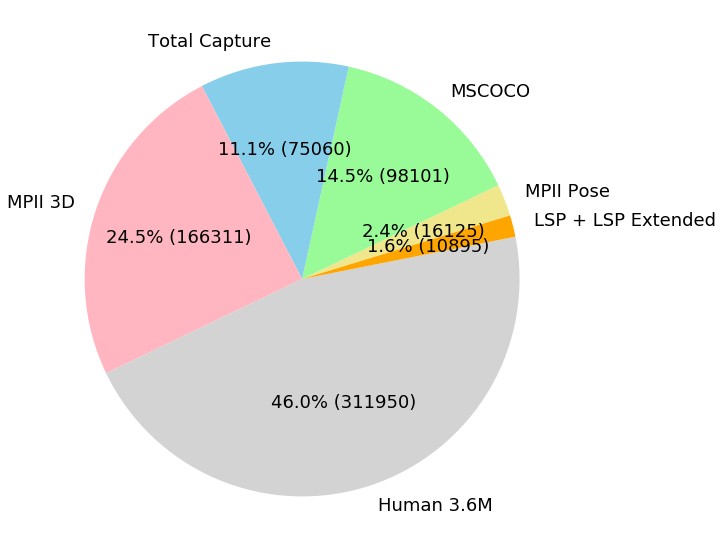

In [16]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        #pct = int(pct)
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

df_train["LSP + LSP Extended"] = df_train['LSP'] + df_train['LSP Extended']
df_plot = df_train.loc['# samples', 'MPII Pose': ]

df_plot.plot.pie(y='# samples', label="", figsize=(10, 10), 
                 colors=['khaki', 'palegreen', 'skyblue', 'lightpink', 'lightgray', 'orange'], 
                 textprops=dict(color="black"), startangle=17, explode=[0, 0,  0, 0, 0, 0],
                 shadow=False, legend=False, fontsize=18, autopct=make_autopct(df_plot))

In [17]:
count_train_val_samples('val')

done: lsp
done: lsp_ext
done: mpii
done: coco
done: total_cap
done: mpii_3d
done: h36m

Total number of train samples: 20864
3d samples: 15883 - 2d samples: 4981


,LSP,LSP Extended,MPII Pose,MSCOCO,Total Capture,MPII 3D,Human 3.6M
# samples,997,NaN,NaN,3984,NaN,NaN,15883
# 3d samples,0,NaN,NaN,0,NaN,NaN,15883
# 2d samples,997,NaN,NaN,3984,NaN,NaN,0


,LSP,LSP Extended,MPII Pose,MSCOCO,Total Capture,MPII 3D,Human 3.6M
# samples,997,NaN,NaN,3984,NaN,NaN,15883
# 3d samples,0,NaN,NaN,0,NaN,NaN,15883
# 2d samples,997,NaN,NaN,3984,NaN,NaN,0


In [18]:
def count_test_samples():
    
    def parse_test(example_proto):
        feature_map = {
            'sequence': tf.io.FixedLenFeature([], dtype=tf.string)
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        sequence = features['sequence']
        return sequence
    
    num_samples, sequence_count = 0, {}
    for dataset in config.DATASETS:
        tf_records = sorted(glob(join(config.DATA_DIR, dataset, '*_test.tfrecord')))
        if len(tf_records) == 0:
            print("done:", dataset)
            continue
            
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_test, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(1) \
            .prefetch(2)

        num_samples_per_ds = 0
        for sequence in ds:
            sequence = sequence.numpy()[0].decode("utf-8")
            if sequence not in sequence_count.keys():
                sequence_count[sequence] = 1
            else:
                sequence_count[sequence] += 1
            num_samples += 1
            num_samples_per_ds += 1
            
        print('done: {} - num_samples {}'.format(dataset, num_samples_per_ds))

    print('Total number of samples in tf records: ', num_samples)

    return json.dumps(sequence_count, indent=4, sort_keys=True)

In [19]:
data_test = count_test_samples()

df_test = pd.read_json(data_test, orient='index')
display(HTML(df_test.to_html()))

done: lsp
done: lsp_ext
done: mpii
done: coco
done: total_cap - num_samples 73871
done: mpii_3d - num_samples 2874
done: h36m - num_samples 110128
Total number of samples in tf records:  186873


,0
TC_S1_acting3_cam1,537
TC_S1_acting3_cam2,126
TC_S1_acting3_cam3,449
TC_S1_acting3_cam4,511
TC_S1_acting3_cam5,391
TC_S1_acting3_cam6,536
TC_S1_acting3_cam7,502
TC_S1_acting3_cam8,536
TC_S1_freestyle3_cam1,408
TC_S1_freestyle3_cam2,125


### inspect visible keypoints 2d

In [20]:
def count_train_kp2d_samples():
    def parse_kp2d(example_proto):
        feature_map = {
            'keypoints_2d': tf.io.FixedLenFeature((config.NUM_KP2D, 3), dtype=tf.float32),
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        kp2d = features['keypoints_2d']
        return kp2d

    result = {}
    for dataset in config.DATASETS:
        tf_records = sorted([glob(join(config.DATA_DIR, dataset, '*_train.tfrecord'))])
        if len(tf_records) == 0:
            print("done:", dataset)
            result[dataset] = np.zeros(19)
            continue

        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_kp2d, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE) \
            .prefetch(config.BATCH_SIZE * 2)

        idx = range(19)
        vis_kps = np.ndarray((19,))
        for kp2d in ds:
            kp2d = kp2d.numpy()
            kps = np.transpose(kp2d, (1, 0, 2))
            for i, kp in zip(idx, kps):
                np_sum = np.sum(kp[:, 2])
                if np_sum > config.BATCH_SIZE:
                    print('error')
                vis_kps[i] = vis_kps[i] + np_sum

        print("done:", dataset)
        result[dataset] = vis_kps

    return result

In [21]:
columns_kp2d = ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m', 'total_cap']
coco_kp2d = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
            'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain', 'nose', 'eye_l', 'eye_r', 'ear_l', 'ear_r']

data_kp2d = count_train_kp2d_samples()

df_kp2d = pd.DataFrame(data_kp2d, index=coco_kp2d, columns=columns_kp2d)
df_kp2d = df_kp2d.astype('int32')
display(HTML(df_kp2d.to_html()))

# if following error occurs just run again
# Cannot convert non-finite values (NA or inf) to integer

done: lsp
done: lsp_ext
done: mpii
done: coco
done: total_cap
done: mpii_3d
done: h36m


,lsp,lsp_ext,mpii,coco,mpii_3d,h36m,total_cap
ankle_r,982,8846,10004,54700,162333,311950,72548
knee_r,979,9112,12088,66033,164217,311950,74179
hip_r,959,8411,12550,77986,164621,311950,74211
hip_l,924,8220,12722,78394,164943,311950,74562
knee_l,961,9049,12170,66114,164168,311950,74279
ankle_l,957,8898,9995,54876,162172,311950,72655
wrist_r,884,8837,13220,71050,163299,311925,72339
elbow_r,920,8807,13611,75400,163401,311938,72054
shoulder_r,913,8673,13320,89953,164447,311950,72000
shoulder_l,830,8535,13260,90615,164514,311950,73827


In [22]:
df_kp2d.to_csv('dataset_kps.csv')

### inspect angles between joints 

In [ ]:
def parse_keypoints(example_proto):
    feature_map = {
        'keypoints_2d': tf.io.FixedLenFeature((config.NUM_KP2D, 3), dtype=tf.float32),
        'keypoints_3d': tf.io.FixedLenFeature((config.NUM_KP3D, 3), dtype=tf.float32),
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    kp2d = features['keypoints_2d']
    kp3d = features['keypoints_3d']
    return kp2d, kp3d

def calc_angle(a, b, c):
    a = np.squeeze(a)
    b = np.squeeze(b)
    c = np.squeeze(c)
    ba = a - b
    bc = c - b

    dot = np.dot(ba, bc)
    cosine_angle =  dot / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    degree = np.degrees(angle)
    return degree

In [ ]:
angles_indices = {
    'angles_2d_r': [0, 1, 2],
    'angles_2d_l': [7, 6, 5],
    'angles_3d_r': [0, 1, 2],
    'angles_3d_l': [7, 6, 5]
}
angle_datasets = ['mpii_3d', 'h36m', 'total_cap']
def check_angles(angle_type):

    result = {}
    for dataset in angle_datasets:
        tf_records = sorted([glob(join(config.DATA_DIR, dataset, '*_train.tfrecord'))])
        if len(tf_records) == 0:
            print("done:", dataset)
            result[dataset] = []
            continue

        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_keypoints, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(1, drop_remainder=True) \
            .prefetch(config.BATCH_SIZE * 2)

        
        angles = angles_indices[angle_type]
        
        data = []
        for kp2d, kp3d in ds:
            kp2d = kp2d.numpy()
            if np.sum(kp2d[:, angles, 2]) != 3:
                continue
                
            kp = kp2d[:,:,:2] if '2d' in angle_type else kp3d.numpy()
            data.append(calc_angle(kp[:, angles[0]], kp[:, angles[1]], kp[:, angles[2]]))
        
        big_angles = np.where(data > np.percentile(data, 90))
        print(big_angles)
        small_angles = np.where(data < np.percentile(data, 10))
        print(small_angles)
        print("done:", dataset)
        
        data = np.nan_to_num(data)
        mean = np.mean(data)
        median = np.median(data)
        std = np.std(data)  
        min_ = data.min() 
        max_ = data.max()
        perc_25 = np.percentile(data, 25)  
        perc_50 = np.percentile(data, 50)  
        perc_75 = np.percentile(data, 75) 
        
        result[dataset] = [mean, median, std, min_, max_, perc_25, perc_50, perc_75]

    return result

In [ ]:
data_angles = []
for angle in angles_indices.keys():
    print('start checking ', angle)
    data_angles.append(check_angles(angle))

In [ ]:
columns_angles = ['mpii_3d', 'h36m', 'total_cap']
index = ['Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']

frames = []
for data in data_angles:
    frames.append(pd.DataFrame(data, index=index, columns=columns_angles)) 

df_angles = pd.concat(frames, axis=1, sort=False, keys=list(angles_indices.keys()))
display(HTML(df_angles.to_html()))

In [ ]:
df_angles.to_csv('angles_distribution.csv')

### inspect smpl/mosh data

In [ ]:
def parse_smpl(example_proto):
    feature_map = {
        'pose': tf.io.VarLenFeature(dtype=tf.float32),
        'shape': tf.io.VarLenFeature(dtype=tf.float32),
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    pose = tf.reshape(tf.sparse.to_dense(features['pose']), (config.NUM_POSE_PARAMS,))
    shape = tf.reshape(tf.sparse.to_dense(features['shape']), (config.NUM_SHAPE_PARAMS,))

    return tf.concat([tf.zeros(3), pose, shape], axis=-1)  # fake cam, pose and shape

In [ ]:
def count_train_smpl_samples():
    result = {}
    for dataset in config.SMPL_DATASETS:
        tf_records = sorted([glob(join(config.SMPL_DATA_DIR, dataset, '*_train.tfrecord'))])
        
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_smpl, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE) \
            .prefetch(config.BATCH_SIZE * 2)

        num_smpl = 0
        for smpl in ds:
            num_smpl += smpl.numpy().shape[0]
            
        print("done:", dataset)
        result[dataset] = num_smpl
        
    return result

In [ ]:
columns_smpl = ['cmu', 'joint_lim']
index_smpl = ['# samples']

data_smpl = count_train_smpl_samples()

df_smpl = pd.DataFrame(data_smpl, index=index_smpl, columns=columns_smpl)
df_smpl = df_smpl.astype('int32')
display(HTML(df_smpl.to_html()))

### serialize example proto

In [ ]:
def print_example(path):
    raw_dataset = tf.data.TFRecordDataset([path])

    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

In [ ]:
path = os.path.join("/data/ssd1/russales/tfrecords_with_toes/total_cap", "305_test.tfrecord")
print_example(path)